# **Lab 5: Naive Bayes Classification**

CS 412

***This lab can be conducted in groups.***

In this lab, you will learn how to apply the Naive Bayes model to filter spam SMS messages. 

***Deadline:***
**23:59 PM, Mar 17**.


<font color='red'> Please refer to `Lab_Guideline.pdf` in the same Google Drive folder as this Jupyter notebook; the guidelines there apply to all the labs.</font>

# **Naive Bayes Classification** {-}

In this problem, you will implement the Naive Bayes classification method and use it for SMS message classifcation. The SMS dataset `SMSSpamCollection` has been provided in the assignment folder, which also can be downloaded from the [UCI Link](http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).  In case the repository gets offline occasionally, we have made local copies for the [dataset](https://www.cs.uic.edu/~zhangx/teaching/SMSSpamCollection.dat) and [readme](https://www.cs.uic.edu/~zhangx/teaching/readme.txt).

To help you to better understand this algorithm, you are **not** allowed to use any off-the-shelf naive Bayes implementations from third-party libraries. We will implement it with detailed step-by-step instructions.

### Recap of the Naive Bayes Algorithm  {-}
Naive Bayes classification is a fast and simple classification method. Its efficiency stems from some simplifications we make about the underlying probability distributions, namely, the assumption about the conditional independence of features. Suppose for any class $Y$, we have a probability distribution over all possible combinations of values for a feature vector $X$:
$$
P(X|Y).
$$
The main idea of Bayesian classification is to reverse the direction of dependence --- we want to predict the label based on the features:
$$
P(Y|X).
$$
This is made possible by the Bayes theorem:
\begin{equation}
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}. \tag{1}
\end{equation}

To make it more concrete, let us consider the SMS message classification problem. Ignoring punctuations, each SMS message contains an ordered sequence of $T$ words (case-insensitive) $X = \{X_1, ...,X_T\}$. That is, $X$ corresponds to an SMS message, and $X_i$ corresponds to the $i$-th word in it. For each message from the training set, there is a corresponding label $Y\in\{spam, ham\}$. 

**Model specification and key assumption.** The conditional distribution can be written as:
$$
P(X|Y) = P(X_1, ..., X_T|Y).
$$
Since this conditional probability is intractable, we simplify it in two steps:

1. **Assume** that all features $X_i$ are independent, conditional on the category $Y$. This leads to a naive Bayes model which writes formally as
\begin{equation}
P(X|Y) = P(X_1, ..., X_T|Y) = \prod_{i=1}^T P(X_i|Y). \tag{2}
\end{equation}

2. **Assume** that $P(X_i | Y) = P(X_j|Y)$ for all $i \neq j$.
In other words, given the label $Y$, the value of the $7$-th word has the same distribution as the value of the $10$-th word. Note this is not assumed by default in naive Bayes, and we make this additional assumption to significantly simplify our model.
It is often referred to as "tying" the probability $P(X_i|Y)$ over $i$.
As a result, the order of words no longer matters for $P(X|Y)$,
i.e., 
$$P(X=\text{'cat is cute'}|Y) \ \ = \ \ P(X=\text{'cute cat is'}|Y) \quad \text{for all } Y.
$$

Plugging Eq (2) into the Bayes theorem in Eq (1), we arrive at
$$
\begin{aligned}
P(Y|X) &= \frac{P(Y) P(X|Y)}{P(X)} = \frac{P(Y)\prod_{i=1}^T P(X_i|Y)}{P(X)} \\
&\propto P(Y)\prod_{i=1}^T P(X_i|Y),
\end{aligned}
$$
where $\propto$ denotes proportionality. Since the denominator $P(X)$ does not depend on $Y$, the prediction probability is proportional to the numerator.

**Making predictions.**
Naturally, given an SMS message $X$, we can first compute $P(Y|X)$ for all possible categories $Y$ (in this example, only two categories), and then make predictions by outputting the $Y$ that maximizes the probability. This can be expressed mathmatically as:
$$
\arg\max_Y P(Y)\prod_{i=1}^T P(X_i|Y) = \arg\max_Y \left\{\log P(Y) + \sum_{i=1}^T \log P(X_i|Y) \right\}. \tag{3}
$$
If there is a tie, we just break it arbitrarily.
Here the logarithm uses natural basis.

**Learning the model.**
To apply the prediction rule in Eq (3), we need to first figure out (formally termed "estimate") the value of $P(Y)$ and $P(X_i|Y)$ by using the training data. Recall that since we tie the conditional probabilities $P(X_i|Y)$ across all $i$,
the subscript $i$ can be dropped.
However, we still carry it just for clarity. 

Firstly, $P(Y=y)$ can be estimated by computing the frequency of category $y$ in the whole training set ($y$ can be either "$spam$" or "$ham$"). Here, in order to avoid confusion, we have used the convention that capital letters denote random variables, and lowercase letters denote their possible instantiations.

Secondly, $P(X_i = w |Y=y)$ for a word $w$ (e.g., "cat") can be estimated by counting the frequency that it appears in the training message set for a given category $y$ (derivation not required in the course):
\begin{align}
P(X_i &= w|Y=y) 
= \frac{Count(w, y)}{Count(y)}, \ \ where
\tag{4} \\
 Count(w, y) &= \text{total number of occurrence of $w$ in all SMS messages of category } y \\
Count(y) &= \text{total number of words appearing in SMS messages of category } y.
\end{align}

*Remark 1:* If $w$ appears in a single message for 3 times, then it contributes to $Count(w, y)$ by 3, not 1. Similarly, $Count(y)$ indeed equals the total length of all messages in category $y$.

*Remark 2:* Obviously, the right-hand side of Eq (4) does not depend on $i$. This is consistent with our previous note that we carry the subscript $i$ in $P(X_i|Y)$ only for clarity, while in fact different $i$ share the same $P(X_i|Y)$.

For example, suppose there are four messages 
$$
\text{{'cat is cute', ham}, {'dog rocks', spam}, {'whatever is is right', ham}, {'hello', spam}.}
$$
Then $P(X_i = '\text{is}' | \text{ham}) = 3 / 7$ (**not** $2/7$),
and $P(X_i = '\text{is}' | \text{spam}) = 0 / 3$.

Quiz (no need to submit): compute $P(X_i = w | \text{ham})$, for $w = $ 'cat', 'is', 'cute', 'whatever', and 'right'. Check if their sum is 1. Now appreciate why in Remark 1, a word appearing for mulitple times in a single message should be counted multiple times.

You may have noticed that any word $w$ with $Count(w,y)=0$ leads to $P(X_i = w|Y=y) = 0$.
As a result, by Eq (2), any message $x$ has conditional probably $P(X = x |Y=y) = 0$ if $w$ appears in $x$.
Such a "veto" is not favorable, and can create significant problems when a word in the test data has never appeared in the training data (think why?).
To bypass this issue, we can add pseudo-count, a.k.a additive smoothing:
$$
\hat{P}(X_i = w|Y=y) = \frac{Count(w, y) + \alpha}{Count(y) + N\alpha}, \tag{5}
$$
where $\alpha$ is a smoothing parameter. $\alpha=0$ corresponds to no smoothing. In our experiment, let us set $\alpha = 1.0$. $N$ denotes the number of distinct words in the vocabulary, and let us set $N = 20,000$ in this lab.

Now Let's start with data preprocessing.

In [1]:
# set up code for this experiment
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

### 1. Data Preprocessing **(25 points)** {-}

We will use `pandas` to import the dataset. Since `SMSSpamCollection` separates labels and text content in each message by a tab, we will use '\t' as the value for the `sep` argument and read raw data into a pandas dataframe. As a result, we store labels and SMS messages into two columns. To facilitate the subsequent steps, we also rename the columns by passing a list `['label', 'sms_message']` to the `names` argument of the `read_table()` method.

Let us print the first five rows of the dataframe to get a basic understanding of the dataset.

In [2]:
# Download the dataset to the server
# Import the data using the read_csv() method from pandas

import urllib.request
import shutil

url = 'https://www.cs.uic.edu/~zhangx/teaching/SMSSpamCollection.dat'
file_name = 'SMSSpamCollection.dat'
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

df = pd.read_csv(file_name,
                    sep='\t',
                    header=None,
                    names=['label', 'sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Step 1: Convert string labels to numerical labels (not for grading) {-}

As we can see, there are 2 columns. The first column, which is named `label`, takes two values `spam` (the message is spam) and `ham` (the message is not spam). The second column is the text content of the SMS message that is being classified.  It is a string in which words are separated by space.

Note that the string-typed labels are unwieldy for calculating performance metrices, e.g., when calculating precision and recall scores. Hence, let's convert the lables to binary variables, 0 for `ham` and 1 for `spam`. 

In [3]:
# Run the next line only once after running the previous code block
# Running it more than once will turn the labels into NaN
#df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()



,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Step 2: Bag of words **(16 points)** {-}

What we have in our dataset is a large collection of text data (5,572 rows/messages). Most ML algorithms rely on numerical data to be fed into them as input, but SMS messages are usually text heavy. 

To address this issue, we would like to introduce the concept of Bag of Words (BoW), which is designed for problems with a 'bag of words' or a collection of text data. The basic idea is to count the frequency of the words in the text. It is important to note that BoW treats each word individually, ignoring the order in which the words occur. 

To count the frequency of the words in text, usually we need to process the input text data in four steps:

- Convert all strings into their lower case form
- Removing all punctuations
- Tokenization, i.e., split a sentence into individual words
- Count frequencies

Once this has been done, we are supposed to obtain a vocabulary dictionary with frequencies of each words for the given text data.

In [4]:
def count_frequency(documents):
    """
    count occurrence of each word in the document set.
    Inputs:
    - documents: list, each entity is a string type SMS message
    Outputs:
    - frequency: a dictionary. The key is the unique words, and the value is the number of occurrences of the word
    
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Step 1: covert all strings into their lower case form
    lower_case_doc = []
    for s in documents:
        lower_case_doc.append(s.lower())
        
    # Step 2: remove all punctuations
    no_punc_doc = []
    for s in lower_case_doc:
        no_punc_doc.append(s.translate(str.maketrans('','',string.punctuation)))
     
    # Step 3: tokenize a sentence, i.e., split a sentence into individual words 
    # using a delimiter. The delimiter specifies what character we will use to identify the beginning 
    # and the end of a word.
    words_doc = []
    for s in no_punc_doc:
        words_doc.append(s.split(' '))
        
    # Step 4: count frequencies. To count the occurrence of each word in the document set. 
    # We can use the `Counter` method from the Python `collections` library for this purpose. 
    # `Counter` counts the occurrence of each item in the list and returns a dictionary with 
    # the key as the item being counted and the corresponding value being the count of that item in the list. 
    all_words = []
    for s in words_doc:
        all_words.extend(s)

    frequency = Counter(all_words)
        
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return frequency

# Unit test case:
# documents = ['Hello, how are you!', 
#              'Win money, win from home.',
#              'Call me now.',
#              'Hello, Call hello you tomorrow?']
# sample outputs:
# Counter({'hello': 3, 'you': 2, 'win': 2, 'call': 2, 'how': 1, 'are': 1, 'money': 1, 'from': 1, 'home': 1,
# 'me': 1, 'now': 1, 'tomorrow': 1})
documents = ['Hello, how are you!',
            'Win money, win from home.',
            'Call me now.',
            'Hello, Call hello you tomorrow?']

freq = count_frequency(documents)


#### Step 3: Create training and test sets **(9 points)** {-}

We will partition the `SMSSpamCollection` dataset into training and test sets so that we can analyze the model's performance on data it has not witnessed during training. In Lab 3, we have implemented the `split_nfold()` method from scratch for data partition. In this Lab, we will learn to use the `scikit` library. `scikit` is a powerfull tool for machine learning and data mining, providing plenty of well-designed methods for data analysis. We'll use its `train_test_split()` method to create training and testing sets. In this experiment, we use 80% data for training and the remaining 20% data for testing. To ensure your results are replicable, you need to set the `random_state` argument of `train_test_split()` to **1**.

There is no cross validation in this Lab.

In [40]:
from sklearn.model_selection import train_test_split

# learn to read API documentation
# you can get detailed instructions about this method through this link:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train, X_test, y_train, y_test = train_test_split(df['sms_message'], df['label'], test_size=.2, random_state=1)

X_test = X_test.tolist()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(f'The original dataset contains {df.shape[0]} examples in total.')
print(f'The training set contains {X_train.shape[0]} examples.')
print(f'The testing set contains {len(X_test)} examples.')




The original dataset contains 5572 examples in total.
The training set contains 4457 examples.
The testing set contains 1115 examples.


### 2. Implementing Naive Bayes method from scratch **(75 points)**{-}

#### Step 1: training the Naive Bayes Model **(25 points)** {-}

Now that we know what Naive Bayes is, we can take a closer look at how to calculate the posterior probability
$$
P(Y|X) \propto P(Y)\prod_{i=1}^T P(X_i|Y).
$$

The goal of training is to learn the prior and conditional probability from data. The calculation of the prior $P(Y=y)$ is straightforward. It can be estimated via the frequency of messages in the training set that belong to class $y$, e.g.,
$$
P(Y=spam) = \frac{\# \text{training messages in the spam category}}{\# \text{training messages}}.
$$

The conditional probability given the class label --- $P(X_i|Y)$ --- can also be estimated from the data by using Eq (5). As we assumed above, it is indeed independent of $i$ (i.e., shared by all $i$). We will leave it to you to translate Eq (5) into a concrete computation scheme. No pseudo-code is provided because by now you should be able to do it. However, do make sure that your implementation complies with the input and output data types as specified in the code.

**Hint**: 
- `count_frequency()` can be useful for computing the conditional probability.
- You need to apply the **pseudo-count** trick to handle unseen words when computing the conditional probability for testing data. It is natual to ask how to carry the quantity Count(y) in Equation 5 through the variables that are passed through the functions.  To address this issue, we can create a 'dummy' entry in cond_prob (the variable returned by the function conditional_prob), and set its value to $\hat{P}(X_i = dummy | Y = y) = \alpha / (Count(y) + N \alpha)$.  Then all the words that appear in test data but not in training data can directly use that entry.  Please do not use other key names than 'dummy', because the auto-grader follows this protocal.

In [56]:
def train_NB_model(X_train, y_train):
    """
    training a naive bayes model from the training data.
    Inputs:
    - X_train: an array of shape (num_train,) which stores SMS messages. each entity is a string type SMS message
    - y_train: an array of shape (num_train,). the ground true label for each training data.
    Output:
    - prior: a dictionary, whose key is the class label, and value is the prior probability.
    - conditional: a dictionary whose key is the class label y, and value is another dictionary.
                   In the latter dictionary, the key is word w, and the value is the
                   conditional probability P(X_i = w | y).
    """

    # To make your code more readable, you can implement some auxiliary functions
    # such as `prior_prob` and `conditional_prob` outside of this train_NB_model function

    # compute the prior probability
    prior = prior_prob(y_train)
    
    # compute the conditional probability
    conditional = conditional_prob(X_train, y_train)

    return prior, conditional

# Start your auxiliary functions
def add_smooth(count_x, count_all, alpha=1.0, N=20000):

    """
    compute the conditional probability for a specific word
    Inputs:
    - count_x: the number of occurrence of the word
    - count_all: the total number of words
    - alpha: smoothing parameter
    - N: the number of different values of feature x
    Outputs:
    - prob: conditional probability
    """
    return (count_x + alpha) / (count_all + N*alpha)

    
def prior_prob(y_train):
    """
    compute the prior probability
    Inputs:
    - y_train: an array that stores ground true label for training data
    Outputs:
    - prior: a dictionary. key is the class label, value is the prior probability.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    prior = {}
    num_train = len(y_train)
    labels = np.unique(y_train)
    for i in range(len(labels)):
        prior[i] = len(y_train[y_train == i])/num_train
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****   
    
    return prior

def conditional_prob(X_train, y_train):
    """
    compute the conditional probability for a document set
    Inputs:
    - X_train: an array of shape (num_train,) which stores SMS messages. each entity is a string type SMS message
    - y_train: an array of shape (num_train,). the ground true label for each training data.
    Ouputs:
    - cond_prob: a dictionary. key is the class label, value is a dictionary in which the key is word, the value is the conditional probability of feature x_i given y.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # docs with label '0' to ham, '1' to spam list
    labels = np.unique(y_train)
    X_train = pd.Series(X_train)
    y_train = pd.Series(y_train)
    num_train = len(X_train)
    
    #FIXME add general case for creating the nested dict
    cond_prob = {0: {} , 1: {}} 

    # empty list with training examples of label 0
    ham = []
    # empty list with training examples of label 1
    spam = []

    # FIXME general case
    for i, v in X_train.items():
        if y_train[i] == 0:
            ham.append(X_train[i])
        else:
            spam.append(X_train[i])
     
    # compute frequency in docs
    freq_ham = count_frequency(ham)
    
    freq_spam = count_frequency(spam)
    
    # calculate conditional probability
    
    # for ham
    count_ham = len(freq_ham) + 1
    # add 0 labels
    for key in freq_ham:
        count_x = freq_ham[key]
        cond_prob[0][key] = add_smooth(count_x, count_ham)
    
    # add dummy case for ham 
    cond_prob[0]['dummy'] = add_smooth(0, count_ham)
    
    # for spam
    count_spam = len(freq_spam) + 1
    # add 1 labels
    for key in freq_spam:
        count_x = freq_spam[key]
        cond_prob[1][key] = add_smooth(count_x, count_spam)
                                    
    # add dummy case for spam 
    cond_prob[1]['dummy'] = add_smooth(0, count_spam)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****   
    
    return cond_prob

 #unit test case:
x_train = ['Hello, how are you!',
            'Win money, win from home.',
           'Call me now.',
           'Hello, Call hello you tomorrow?']
#y_train = np.array([0,1,1,0,1])

# sample outputs:
# prior: {0: 0.5, 1: 0.5}
# conditional: {0: {'hello': 0.0001999100404817832, 'how': 9.99550202408916e-05, 
#                   'are': 9.99550202408916e-05, 'you': 0.0001499325303613374, 
#                   'call': 9.99550202408916e-05, 'tomorrow': 9.99550202408916e-05,
#                   'dummy': 4.99775101204458e-05}, 
#               1: {'win': 0.00014994002399040384, 'money': 9.996001599360256e-05, 
#                   'from': 9.996001599360256e-05, 'home': 9.996001599360256e-05, 
#                   'call': 9.996001599360256e-05, 'me': 9.996001599360256e-05, 
#                   'now': 9.996001599360256e-05}, 'dummy': 4.998000799680128e-05}}
#x_train = np.array(['Hello, how are you!',
#            'Win money, win from home.',
 #           'Call me now.',
  #          'Hello, Call hello you tomorrow?'])
y_train_mini = np.array([0,1,1,0])

prior = prior_prob(y_train_mini)
cond_prob = conditional_prob(x_train, y_train_mini)
print(prior, cond_prob)


{0: 0.5, 1: 0.5} {0: {'hello': 0.000199930024491428, 'how': 9.9965012245714e-05, 'are': 9.9965012245714e-05, 'you': 0.000149947518368571, 'call': 9.9965012245714e-05, 'tomorrow': 9.9965012245714e-05, 'dummy': 4.9982506122857e-05}, 1: {'win': 0.00014994002399040384, 'money': 9.996001599360256e-05, 'from': 9.996001599360256e-05, 'home': 9.996001599360256e-05, 'call': 9.996001599360256e-05, 'me': 9.996001599360256e-05, 'now': 9.996001599360256e-05, 'dummy': 4.998000799680128e-05}}


#### Step 2: predict label for test data **(25 points)** {-}

Once we have the two models $P(Y)$ and $P(X_i|Y)$ from *training*, we can use them to predict the label for a given test message. To this end, we need to compute the probability of all possible labels, and then predict the one with maximum probability value:
$$
\arg\max_Y P(Y)\prod_{i=1}^T P(X_i|Y). \tag{6}
$$

**Avoid numerical underflow with log-trick.**
As shown in the above equation, the calculation involves multiplying many probabilities together. Since probabilities lie in $(0,1]$, multiplying many of them together can lead to numerical underflow (i.e., a floating point number close to 0 gets rounded down to 0 by a computer), especially when $T$ is large, i.e., the test message is long.

To overcome this problem, it is common to change the calculation from the product of probabilities to the sum of log probabilities. 
That is, take the natual logarithm of the right-hand side of Eq (6) as
$$
g_Y(X) = \log P(Y) + \sum_{i=1}^T \log P(X_i|Y). \tag{7}
$$
It is much more numerically stable to compute $g_Y(X)$ and to take $\arg\max_Y g_Y(X)$ to find the most likely class label (as the output prediction). 

With $g_Y(X)$, we can easily compute the posterior probability by
$$
P(Y|X) = \frac{\exp (g_Y(X) - m)}{\sum_y \exp (g_y(X)-m)},
\text{ where  }
m = \max_y g_y(X).
$$
In our message classification problem, the summation in the denominator is just over `positive` and `negative`.
Note we subtract by $m$, which does not change the result because the numerator and denominator cancel.
However it is numerically useful because sometimes all $g_Y(X)$ are overly small and can cause numerical underflow inside exponentiation.
By subtracting $m$, $g_Y(X) - m$ will be 0 (properly scaled) for at least one value of $Y$, and be negative for the other.  And even if another $y$ still suffers underflow in exponentiating $g_y(X)-m$, the posterior probabilities will still be correct.

Again, you are expected to implement Eq (7) and loop over all test examples by yourself with no pseudo-code given.

In [43]:
from scipy.special import softmax
def predict_label(X_test, prior_prob, cond_prob):
    """
    predict the class labels for the testing set
    Inputs:
    - X_test: an array of shape (num_test,) which stores test data. 
              Each entity is a string type SMS message.
    - prior_prob: a dictionary which stores the prior probability for all categories
              We previously used "prior_prob" as the name of function.  
              Here it is used as a dictionary name.  No confusion should arise.
    - cond_prob: a dictionary whose key is the class label y, and value is another dictionary.
                   In the latter dictionary, the key is word w, and the value is the
                   conditional probability P(X_i = w | y).
    Outputs:
    - predict: an array that stores predicted labels
    - test_prob: an array of shape (num_test, num_classes) which stores the posterior probability of each class
    """

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # initialize variables
    num_test = len(X_test)
    num_class = len(prior_prob)
    # empty list to hold test probs calculated each index is a class
    prob = np.empty((num_test, num_class))
    predict = np.empty(num_test)
    #word_count = {}
    
    # predict label
    # iterate over all entries in X_test 
    for i in range(num_test):
        # find word count of specific text example
        #word_count = count_frequency([X_test[i]])
        # compute conditional probability for j classes
        for j in range(num_class):
            # calculate sum of log probabilities
            prob[i][j] = compute_test_prob(count_frequency([X_test[i]]), prior_prob[j],cond_prob[j])
     
    
    # predict is argmax of each row of prob
    predict = prob.argmax(axis=1)

    # calculate posterior probability, subtract predict for computational ease
    # create empty matrix for calculation
    prob_minus_m = np.empty((num_test, num_class))
    for i in range(num_test):
        m = prob[i][predict[i]]
        vm = np.full((num_class, ), m)
        prob_minus_m[i] = vm
    
    test_prob = softmax(prob - vm)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return predict, test_prob

def compute_test_prob(word_count, prior_cat, cond_cat):
    """
    predict the class label for one test example
    Inputs:
    - word_count: a dictionary which stores the frequencies of each word in a SMS message. 
                  Key is the word, value is the number of its occurrence in that message
    - prior_cat: a scalar. prior probability of a specific category
    - cond_cat: a dictionary. conditional probability of a specific category
    Outputs:
    - prob: discriminant value g_y of a specific category for the test example 
                  (no need of normalization, i.e., not exactly the posterior probability)
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    #initialize conditional probability  
    log_cond_prob = 0
    # fetch cond prob of each word in i of x_test from cond prob dict
    for w, n in word_count.items():
        if w in cond_cat:
            log_cond_prob +=  n * np.log(cond_cat[w])
        else:
            log_cond_prob +=  n * np.log(cond_cat['dummy'])
     
    prob = np.log(prior_cat) + log_cond_prob
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return prob

# unit test case:
# x_test = np.array(['Hello, how are you!'])
# sample outputs:
# y_pred: [0] 
# test_prob: [[0.97958684 0.02041316]]
x_test = np.array(['Hello, how are you today!'])
y_pred, test_prob = predict_label(x_test, prior, cond_prob)
print(y_pred, test_prob)

[0] [[0.97959683 0.02040317]]


#### Step 3: compute performance metrics **(9 points)** {-}
You may have noticed that the classes are heavily imbalanced. There are only 747 `spam` messages, compared with 4827 `ham` messages. If a classifier simply predicts all messages as `ham`, it will get around 86% accuracy (pretty high). Therefore, accuracy is not a good metric in this case for evaluating the performance of the classifier. As we did before, we can use F-score metrics. But this time we will not implement it from the scratch. Instead, we will learn how to use the builtin methods from `scikit`. [Here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) is a summary of well-implemented and commonly used metrics for evaluating the quality of a model's predictions. 

In this task, you need to **report** the testing accuracy, confusion matrix, and F1 score of the Naive Bayes method by choosing proper functions from `scikit` to compute those metrics with required arguments.

Hint: you need to import methods from `sklearn.metrics` before using them.

In [45]:
def compute_metrics(y_pred, y_true):
    """
    compute the performance metrics
    Inputs:
    - y_pred: an array of predictions
    - y_true: an array of ground true labels
    Outputs:
    - acc: accuracy
    - cm: confusion matrix
    - f1: f1_score
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    from sklearn.metrics import accuracy_score
    # compute accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # f1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_true, y_pred)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return acc, cm, f1

# unit test case:
# y_pred = np.array([0,1,1,1,0,1])
# y_true = np.array([0,1,0,0,1,1])
# 
# sample outputs:
# acc: 0.5 
# cm: [[1 2]
#      [1 2]] 
# f1: 0.5714285714285715
y_pred = np.array([0,1,1,1,0,1])
y_true = np.array([0,1,0,0,1,1])
acc, cm, f1 = compute_metrics(y_pred, y_true)
print(acc, cm, f1)

0.5 [[1 2]
 [1 2]] 0.5714285714285715


#### Step 4: Plot ROC curve and print other results **(16 points)** {-}

ROC (Receiver Operating Characteristics) curve is one of the most commonly used metrics for evaluating the performance of machine learning algorithms, especially when the classes are imbalanced.

ROC is a probability curve for different classes. ROC tells us how good the model is for distinguishing the given classes, in term of the **predicted probability** (not the final hard label in pos/neg). A typical ROC curve has False Positive Rate (FPR) on the $x$-axis and True Positive Rate (TPR) on the $y$-axis. To obtain the FPR and TPR, you can use the `roc_curve` method from `scikit`. This `roc_curve` function takes two arguments: 1) the ground truth labels of the test examples, and 2) the predicted probability that each example is positive. It returns the FPR and TPR which can be used for plotting.

You can even compute the area under the curve (AUC) by calling `roc_auc_score` which takes the same arguments as `roc_curve` required.

In this task, **plot** the ROC curve and compute the AUC score.

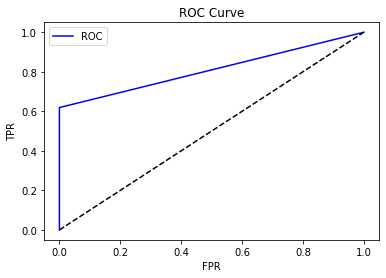

AUC score:  1.0 test accuracy:  0.9497757847533632 F-score:  0.7647058823529412 Confusion matrix:  [[968  56]
 [  0  91]]


In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color='blue', label='ROC')
  plt.plot([0, 1], [0, 1], color='black', linestyle='--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

# We now compute the test performance.
# X_train, X_test, y_train, y_test are the same as above

# training naive Bayes model 
prior, cond = train_NB_model(X_train, y_train)


# evaluate on test set
y_pred, prob = predict_label(X_test, prior, cond)


# Implement the following:
#   1. compute the fpr and tpr for roc curve using the probability of being positive
#   2. compute the auc score
#   3. plot roc curve by calling the plot_roc_curve() method
#   4. print AUC score, test accuracy, F-score, and Confusion matrix

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****  
# 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# 2
auc = roc_auc_score(y_test, y_pred )
# 3 
plot_roc_curve(fpr, tpr)

#4
acc, cm, f1 = compute_metrics(y_test, y_pred)
print("AUC score: ", roc_auc_score(fpr, tpr), "test accuracy: ", acc, "F-score: ", f1, "Confusion matrix: ", cm)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Submission Instruction {-}

You're almost done! Take the following steps to finally submit your work.

1. After executing all commands and completing this notebook, save your `Lab_5.ipynb` as a PDF file, named as `X_Y_UIN.pdf`, where `X` is your first name, `Y` is your last name, and `UIN` is your UIN. Make sure that your PDF file includes all parts of your solution, including the plots. 

> * Print out all unit test case results before printing the notebook into a PDF.
* If you use Colab, open this notebook in Chrome.  Then File -> Print -> set Destination to "Save as PDF".  If the web page freezes when printing, close Chrome and reopen the page. If Chrome doesn't work, try Firefox.
* If you are working on your own computer, we recommend using the browser (not jupyter) for saving the PDF. For Chrome on a Mac, this is under *File->Print...->Open PDF in Preview*. When the PDF opens in Preview, you can use *Save...* to save it.
* Sometimes, a figure that appears near the end of a page can get cut.  In this case, try to add some new lines in the preceding code block so that the figure is pushed to the beginning of the next page. Or insert some text blocks.

2. Upload `X_Y_UIN.pdf` to Gradescope under `Lab_5_Written`.

3. A template of `Lab_5.py` has been provided.  For all functions in `Lab_5.py`, copy the corresponding code snippets you have written into it, excluding the plot code.  **Do NOT** copy any code of plotting figures and do not import **matplotlib**.  This is because the auto-grader cannot work with plotting.  **Do NOT** change the function names.  

4. Zip `Lab_5.py` and `Lab_5.ipynb` (**2 files**) into a zip file named `X_Y_UIN.zip`. Suppose the two files are in the folder `Lab_5`.  Then zip up the **two files inside the `Lab_5` folder**.  **Do NOT zip up the folder `Lab_5`** because the auto-grader cannot search inside a folder. Submit this zip file to Gradescope under `Lab_5_Code`. 

5. The autograder on Gradscope will be open all the time. We designed some simple test cases to help you check wehther your functions are executable. You will see the results of running autograder once you submit your code. Please follow the error messages to debug. Since those simple test cases are designed for debugging, it does not guaranttee your solution will work well on the real dataset. It is your responsibility to make your code logically correct. Since all functions are tested in batch, the autograder might take a few minutes to run after submission.

<font color='red'>If you *only* try to get real-time feedback from auto-grader, it will be fine to just upload `Lab_5.py` to `Lab_5_Code`</font>.  However, the final submission for grading should still follow the above point 4.

You can submit to Gradescope as often as you like. We will only consider your last submission before the deadline.